# Reaction-diffusion model

This Jupyter Notebook presents the context and set-up for the coding assignment of Module 4: *Spreading out: Diffusion problems*, of the course [**"Practical Numerical Methods with Python"**](https://github.com/numerical-mooc/numerical-mooc) (a.k.a., numericalmooc).

So far in this module, we've studied diffusion in 1D and 2D. Now it's time to add in some more interesting physics.  You'll study a model represented by *reaction-diffusion* equations.  What are they?  The name says it all—it's a system that has the physics of diffusion but also has some kind of reaction that adds different behaviors to the solution.

We're going to look at the _Gray-Scott model_, which simulates the interaction of two generic chemical species reacting and ... you guessed it ... diffusing! Some amazing patterns can emerge with simple reaction models, eerily reminiscent of patterns formed in nature. It's fascinating! Check out this simulation by Karl Sims posted on You Tube ... it looks like a growing coral reef, doesn't it?

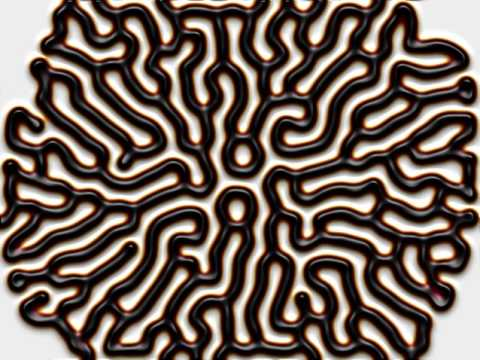

In [1]:
from IPython.display import YouTubeVideo


YouTubeVideo('8dTmUr5qKvI')

## Gray-Scott model

The Gray-Scott model represents the reaction and diffusion of two generic chemical species, $U$ and $V$, whose concentration at a point in space is represented by variables $u$ and $v$. The model follows some simple rules.  

* Each chemical _diffuses_ through space at its own rate.
* Species $U$ is added at a constant feed rate into the system.
* Two units of species V can 'turn' a unit of species U into V: $\; 2 V + U \rightarrow 3 V$
* There's a constant kill rate removing species $V$.

This model results in the following system of partial differential equations for the concentrations $u(x,y,t)$ and $v(x,y,t)$ of both chemical species:

$$
\begin{align}
    \frac{\partial u}{\partial t} &= D_u \nabla^2 u - u v^2 + F (1 - u)\\
    \frac{\partial v}{\partial t} &= D_v \nabla^2 v + u v^2 - (F + k) v
\end{align}
$$

You should see some familiar terms, and some unfamiliar ones.  On the left-hand side of each equation, we have the time rate of change of the concentrations. The first term on the right of each equation correspond to the spatial diffusion of each concentration, with $D_u$ and $D_v$ the respective rates of diffusion.

In case you forgot, the operator $\nabla ^2$ is the Laplacian:

$$
\nabla ^2 u = \frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}
$$

The second term on the right-hand side of each equation corresponds to the reaction. You see that this term decreases $u$ while it increases $v$ in the same amount: $uv^2$.  The reaction requires one unit of $U$ and two units of $V$,  resulting in a reaction rate proportional to the concentration $u$ and to the square of the concentration $v$. This result derives from the _law of mass action_, which we can explain in terms of probability: the odds of finding one molecule of species $U$ at a point in space is proportional to the concentration $u$, while the odds of finding two molecules of $V$ is proportional to the concentration squared, $v^2$. We assume here a reaction rate constant equal to $1$, which just means that the model is non-dimensionalized in some way.

The final terms in the two equations are the "feed" and "kill" rates, respectively: $F(1-u)$ replenishes the species $U$ (which would otherwise run out, as it is being turned into $V$ by the reaction); $-(F+k)v$ is diminishing the species $V$ (otherwise the concentration $v$ would simply increase without bound). 

The values of $F$ and $k$ are chosen parameters and part of the fun of this assignment is to change these values, together with the diffusion constants, and see what happens.

## Problem setup

The system is represented by two arrays, `U` and `V`, holding the discrete values of the concentrations $u$ and $v$, respectively.  We start by setting `U = 1` everywhere and `V = 0` everywhere, then introduce areas of difference, as initial conditions.  We then add a little noise to the whole system to help the $u$ and $v$ reactions along.  

Below is the code segment we used to generate the initial conditions for `U` and `V`.  

**NOTE**: *DO NOT USE THIS CODE IN YOUR ASSIGNMENT*.
We are showing it here to help you understand how the system is constructed.  However, you _must use the data we've supplied below_ as your starting condition or your answers will not match those that the grading system expects.

```python
def create_initial_solution(n, num_blocks, r, v1, v2, noise):
    randx = numpy.random.randint(1, n - 1, num_blocks)
    randy = numpy.random.randint(1, n - 1, num_blocks)
    u0 = numpy.ones((n, n))
    v0 = numpy.zeros((n, n))
    for i, j in zip(randx, randy):
        i1, i2 = i - r, i + r
        j1, j2 = j - r, j + r
        u0[j1:j2, i1:i2] = v1
        v0[j1:j2, i1:i2] = v2
    u0 += noise * numpy.random.random((n, n))
    v0 += noise * numpy.random.random((n, n))
    return u0, v0

u0, v0 = create_initial_solution(nx, 40, 10, 0.50, 0.25, 0.05)
filepath = 'uvinitial.npz'
with open(filepath, 'wb') as outfile:
    numpy.savez(outfile, U=u0, V=v0)
```

## Initial condition data files

We are going to load the initial solution of the species concentrations from the file `uvinitial.npz`.
This is a NumPy save-file that contains two NumPy arrays, holding the initial values for `U` and `V`, respectively.  You can load and plot the initial data using the following code snippets.

In [2]:
import numpy
from matplotlib import pyplot, cm

%matplotlib inline

In [3]:
# Load the initial data from file.
filepath = 'uvinitial.npz'
with open(filepath, 'rb') as infile:
    data = numpy.load(infile)
    u0, v0 = data['U'], data['V']

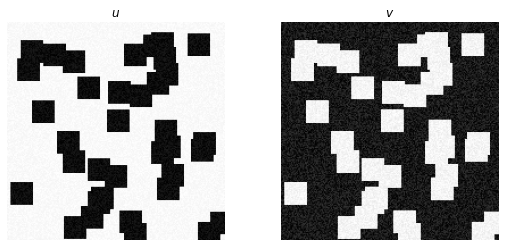

In [4]:
# Plot the initial data.
fig, (ax1, ax2) = pyplot.subplots(ncols=2, figsize=(9.0, 4.0))
ax1.set_title('$u$')
ax1.imshow(u0, cmap=cm.Greys_r)
ax1.axis('off')
ax2.set_title('$v$')
ax2.imshow(v0, cmap=cm.Greys_r)
ax2.axis('off');

---

## Your assignment

Compute the solution of the reaction-diffusion equations using the **midpoint method** (also called modified Euler's method) using a **central-difference discretization** for the spatial second-order derivatives.

**Parameters:**

* Rates of diffusion: $D_u = 0.00016$, $D_v = 0.00008$.
* Feed and kill parameters: $F = 0.035$, $k = 0.060$.
* Domain: $5 \rm m \times 5 \rm m$.
* Uniform grid with $192 \times 192$ points ($\Delta x = \Delta y = \delta$).
* Time-step size: $\Delta t = \frac{9}{40} \frac{\delta^2}{\max \left( D_u, D_v \right)}$.
* Number of time steps: $nt = 1000$.
* Use zero-gradient Neumann boundary conditions on all sides of the domain.

Below is an animated gif showing the solution over $1000$ time steps (with $100$ time steps between two consecutive frames).

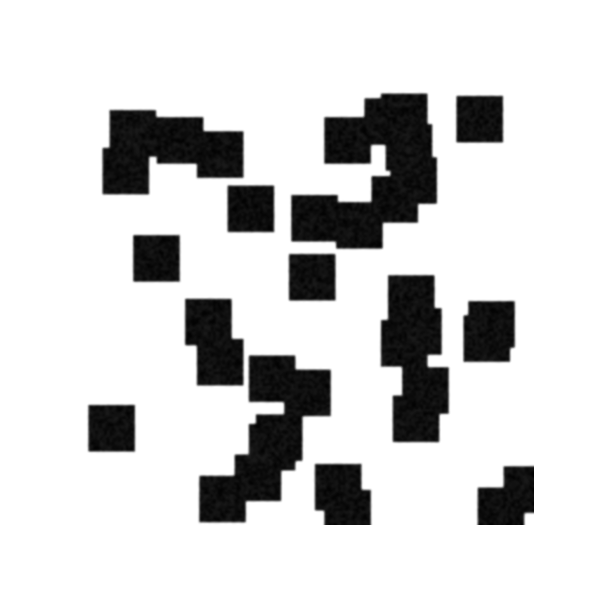

In [5]:
from IPython.display import Image


Image(filename="figures/zebrafish.gif", width=400, height=400)

## Implement your solution (50 points)

Implement your solution in this section.
You can use as many code cells as you want.

In [6]:
# YOUR CODE HERE
# Laplacian for u and v
def Laplacian(u, dx, dy):
    L = ((u[1:-1, :-2] - 2 * u[1:-1, 1:-1] + u[1:-1, 2:]) / dx**2 +(u[:-2, 1:-1] - 2 * u[1:-1, 1:-1] + u[2:, 1:-1]) / dy**2)
    return L

In [7]:
# Right hand side, return for u and v
def rhs(t, u, v, dx, dy, Du, Dv, F, k):
    uvv = u[1:-1, 1:-1] * v[1:-1, 1:-1] * v[1:-1, 1:-1]
    rhs_u = Du * Laplacian(u, dx, dy) - uvv + F * (1 - u[1:-1, 1:-1])
    rhs_v = Dv * Laplacian(v, dx, dy) + uvv - (F + k) * v[1:-1, 1:-1]
    return rhs_u, rhs_v

In [8]:
# Gray-Scott model update
# Use rk2 to improve accuracy
def rk2(t, u, v, dt, f, dx, dy, Du, Dv, F, k):
    n, m = f(t, u, v, dx, dy, Du, Dv, F, k) # rhs for predictor
    u_predictor = u.copy()
    v_predictor = v.copy()
    # Predictor
    u_predictor[1:-1, 1:-1] = u[1:-1, 1:-1] + dt/2 * n
    v_predictor[1:-1, 1:-1] = v[1:-1, 1:-1] + dt/2 * m
    # Update boundary condictions
    u_predictor[-1, :] = u_predictor[-2, :]
    u_predictor[:, -1] = u_predictor[:, -2]
    u_predictor[0, :] = u_predictor[1, :]
    u_predictor[:, 0] = u_predictor[:, 1]
    v_predictor[-1, :] = v_predictor[-2, :]
    v_predictor[:, -1] = v_predictor[:, -2]
    v_predictor[0, :] = v_predictor[1, :]
    v_predictor[:, 0] = v_predictor[:, 1]
    # Corrector
    n_2, m_2 = f(t, u_predictor, v_predictor, dx, dy, Du, Dv, F, k) # rhs for corrector
    u[1:-1, 1:-1] = u[1:-1, 1:-1] + dt * n_2
    v[1:-1, 1:-1] = v[1:-1, 1:-1] + dt * m_2
    # Update boundary condictions
    u[-1, :] = u[-2, :]
    u[:, -1] = u[:, -2]
    u[0, :] = u[1, :]
    u[:, 0] = u[:, 1]
    v[-1, :] = v[-2, :]
    v[:, -1] = v[:, -2]
    v[0, :] = v[1, :]
    v[:, 0] = v[:, 1]
    return u, v

In [9]:
# Set spatial parameters.
Lx, Ly = 5.0, 5.0  # domain dimensions
nx, ny = 192, 192  # number of points in each direction
dx, dy = Lx / (nx - 1), Ly / (ny - 1)  # grid spacings

# Create the gridline locations.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Set parameters of the pattern.
Du, Dv = 0.00016, 0.00008  # rates of diffusion
F, k = 0.035, 0.060  # parameters to feed and kill

# Set temporal parameters.
t0 = 0.0
t = 8000
dt = 9.0 * dx**2 / (40.0 * max(Du, Dv))  # time-step size
nt = 1000  # number of time steps

In [10]:
# Update to 1000 steps
u, v = u0, v0
u_hist = [] # Create an empty list to store the value of u at each step
v_hist = [] # Create an empty list to store the value of u at each step
for i in range(nt):
    u, v = rk2(t, u, v, dt, rhs, dx, dy, Du, Dv, F, k)
    u_hist.append(u.copy())
    v_hist.append(v.copy())

## Assessment (50 points)

Answer questions in this section.

Do not try to delete or modify the cells that are already present.
For each question, make sure to provide your answer in the cell **just above** the empty cell.
(This empty cell contains hidden tests to assert the correctness of your answer and cannot be deleted.)
Pay attention to the name of the variables we ask you to create to store computed values; if the name of the variable is misspelled, the test will fail.

In [11]:
try:
    import mooc37 as mooc
except:
    import mooc36 as mooc

* **Q1 (10 points):** Plot the concentration of the species $U$ at the final time (i.e., after $1000$ time steps)?

In [12]:
# YOUR CODE HERE
import ipywidgets


def plot_species_concentration(u_hist, state):
    fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
    ax.imshow(u_hist[state], vmin=0.5, vmax=1.0,
              interpolation='bicubic', cmap=cm.Greys_r)
    ax.axis('off')


def interactive_figure(u_hist):
    nt = len(u_hist) - 1
    state_slider = ipywidgets.IntSlider(value=0, min=0, max=nt,
                                        step=1,
                                        description='state')
    w = ipywidgets.interactive(plot_species_concentration,
                               u_hist=ipywidgets.fixed(u_hist),
                               state=state_slider)
    return w


# Display the history of the first species concentration.
display(interactive_figure(u_hist))

interactive(children=(IntSlider(value=0, description='state', max=999), Output()), _dom_classes=('widget-inter…

* **Q2 (10 points):** After $1000$ time steps, what is the NumPy array returned by `u[100, ::40]` (replacing `u` with whatever the name of your $u$ array is)?

Store your result in the variable `u_sample`; you can check your answer by calling the function `mooc.check('hw4_u_sample', u_sample)`.

In [13]:
# YOUR CODE HERE
a = u_hist[-1].copy()
u_sample = a[100, ::40]
print(u_sample)
mooc.check('hw4_u_sample', u_sample)

[0.7264022  0.46812277 0.42717747 0.78988153 0.7133075 ]
[hw4_u_sample] Good job!


* **Q3 (10 points):** After $1000$ time steps, what is the minimum of the concentration for the $U$ species?

Store your result in the variable `u_min`; you can check your answer by calling the function `mooc.check('hw4_u_min', u_min)`.

In [14]:
# YOUR CODE HERE
u_min = numpy.min(u)
print(u_min)
mooc.check('hw4_u_min', u_min)

0.2601667676530689
[hw4_u_min] Good job!


* **Q4 (10 points):** After $1000$ time steps, what are the row and column indices of the minimum concentration for the $U$ species?

Store the row index in the variable `row` and the column index in the variable `col`; you can check your answer by calling the function `mooc.check('hw4_row_col', [row, col])`.

In [15]:
# YOUR CODE HERE


* **Q5 (10 points):** After $1000$ time steps, what is the maximum value in the $91^{\rm {th}}$ row of the 2D array with the concentration for the $V$ species?

Store your answer in the variable `v_max`; you can check your answer by calling the function `mooc.check('hw4_v_max', v_max)`.

In [16]:
# YOUR CODE HERE
v = v_hist[-1].copy()
v_max = numpy.max(v[90])
print(v_max)
mooc.check('hw4_v_max', v_max)

0.35988855556668536
[hw4_v_max] Good job!


---

## Exploring extra patterns

Once you have completed the assignment, you might want to explore a few more of the interesting patterns that can be obtained with the Gray-Scott model.  The conditions below will result in a variety of patterns and should work without any other changes to your existing code.

In [17]:
#Du, Dv, F, k = 0.00014, 0.00006, 0.035, 0.065 # Bacteria 2
#Du, Dv, F, k = 0.00016, 0.00008, 0.060, 0.062 # Coral
#Du, Dv, F, k = 0.00019, 0.00005, 0.060, 0.062 # Fingerprint
#Du, Dv, F, k = 0.00010, 0.00010, 0.018, 0.050 # Spirals
#Du, Dv, F, k = 0.00012, 0.00008, 0.020, 0.050 # Spirals Dense
#Du, Dv, F, k = 0.00010, 0.00016, 0.020, 0.050 # Spirals Fast
#Du, Dv, F, k = 0.00016, 0.00008, 0.020, 0.055 # Unstable
#Du, Dv, F, k = 0.00016, 0.00008, 0.050, 0.065 # Worms 1
#Du, Dv, F, k = 0.00016, 0.00008, 0.054, 0.063 # Worms 2
#Du, Dv, F, k = 0.00016, 0.00008, 0.035, 0.060 # Zebrafish

---

## References

*  Reaction-diffusion tutorial, by Karl Sims
http://www.karlsims.com/rd.html

*  Pearson, J. E. (1993). [Complex patterns in a simple system](http://www.sciencemag.org/content/261/5118/189), _Science_, Vol. 261(5118), 189-192 // [PDF](http://www3.nd.edu/~powers/pearson.pdf) from nd.edu.

*  Pattern Parameters from [http://www.aliensaint.com/uo/java/rd/](http://www.aliensaint.com/uo/java/rd/)